Running inference...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.29it/s]



Posterior parameter estimates:
Susceptibility: Mean = 0.9726, HDI = [-0.0732, 2.6056]
Age Factor: Mean = 0.3401, HDI = [0.0004, 0.5016]
Group Factor: Mean = 2.7001, HDI = [0.0219, 4.3033]
Imbalance Offset: Mean = 1.4658, HDI = [0.2439, 3.5717]
Imbalance Slope: Mean = 2.4045, HDI = [0.0359, 3.8780]
Imbalance SD: Mean = 0.1844, HDI = [0.1201, 0.2985]


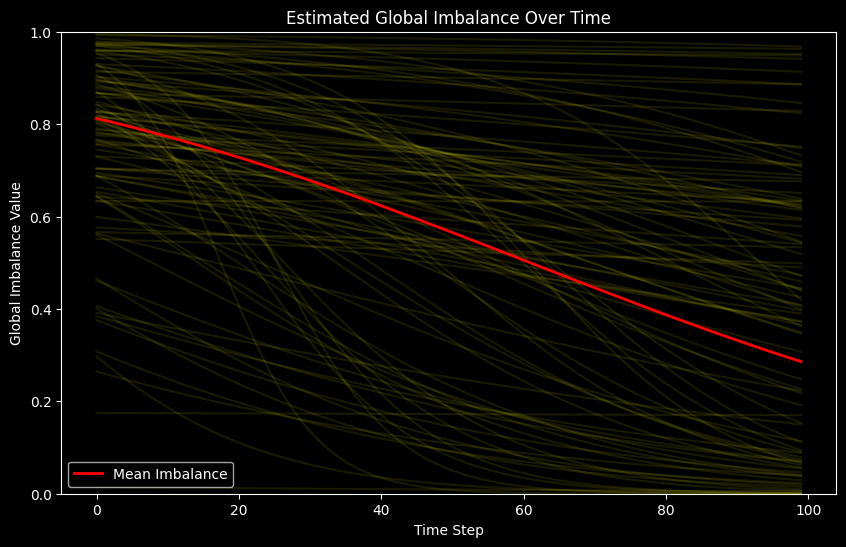

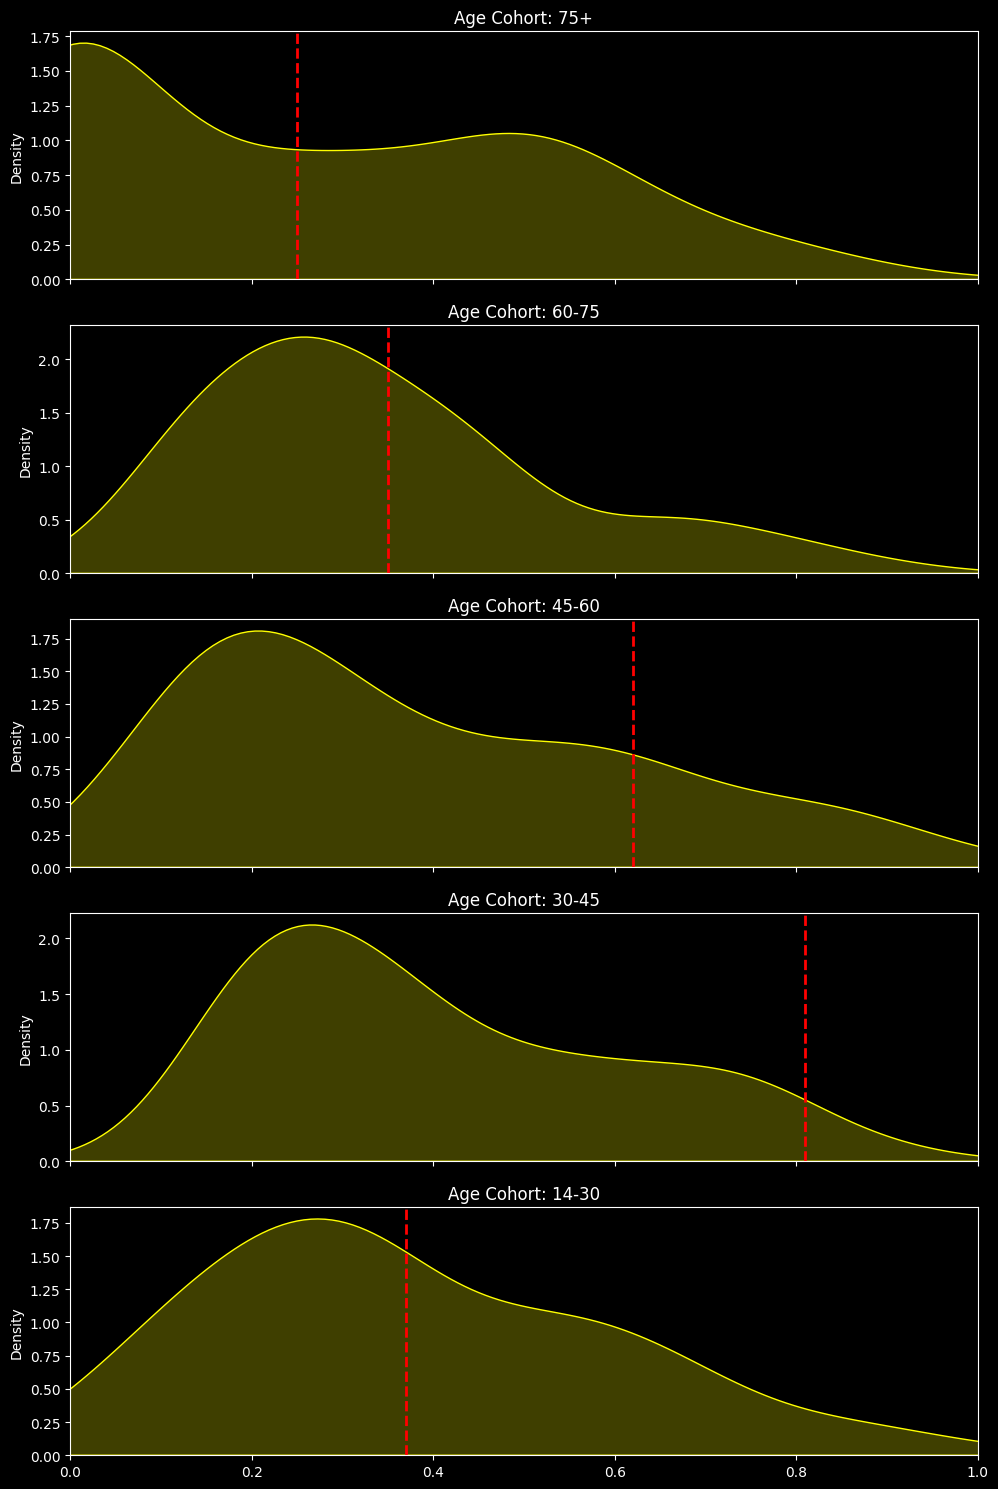

In [2]:
import numpy as np
import numpy.random as rand
import random
import pandas as pd
import matplotlib.pyplot as plt
from types import MethodType
from arviz import hdi
import patsy as pt
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import beta, norm
from scipy.special import expit
from scipy.integrate import quad
import seaborn as sns
import pickle
from tqdm import tqdm
plt.style.use('dark_background')
np.random.seed(42)
import sys

def progress_bar(i, max_i, length=50):
    progress = (i + 1) / max_i
    bar_length = int(length * progress)
    bar = '=' * bar_length + '-' * (length - bar_length)
    sys.stdout.write(f'\r[{bar}] {int(progress * 100)}%')
    sys.stdout.flush()

# Modified Agent class with an imbalance attribute
class Agent:
    def __init__(self, variant, age, susceptibility, imbalance):
        self.variant = variant
        self.age = age
        self.susceptibility = susceptibility
        self.imbalance = imbalance  # Agent-specific imbalance parameter
        
    def change_variant(self):
        if self.variant == 0:
            self.variant = 1
        else:
            self.variant = 0

# Function to model global imbalance over time
def global_imbalance(t, a, b, max_time):
    # Normalize t to be between 0 and 1
    normalized_t = t / max_time
    return 1/(1 + np.exp(-a + b*normalized_t))

class Model:
    def __init__(self, agent, init_size, init_p):
        self.agent = agent
        self.size = init_size
        self.init_p = init_p

    def populate(self, susceptibility, global_imb, imb_sd):
        """
        Initialize population with agent-specific imbalance values
        """
        arr = []
        # Agents with variant 1
        for i in range(np.round(self.size*self.init_p).astype('int')):
            # Assign imbalance value based on global imbalance with some noise
            imbalance = np.clip(np.random.normal(global_imb, imb_sd), 0.01, 0.99)
            arr.append(self.agent(1, 
                                  np.round(np.random.uniform(0, 80, 1)[0]), 
                                  np.random.normal(susceptibility, 0.05),
                                  imbalance))
        # Agents with variant 0
        for i in range(self.size-len(arr)):
            imbalance = np.clip(np.random.normal(global_imb, imb_sd), 0.01, 0.99)
            arr.append(self.agent(0,
                                 np.round(np.random.uniform(0, 80, 1)[0]),
                                 np.random.normal(susceptibility, 0.05),
                                 imbalance))
        return arr

    def birth(self, parents, nbirth, global_imb, imb_sd):
        """
        Create new agents with imbalance inherited from the global parameter
        """
        if not parents or nbirth <= 0:
            return []
            
        # Sample parents with replacement if there are fewer parents than nbirth
        if len(parents) < nbirth:
            parent_chosen = random.choices(parents, k=nbirth)
        else:
            parent_chosen = random.sample(parents, nbirth)
            
        # Create new agents, inheriting variant but with new imbalance values
        arr = []
        for a in parent_chosen:
            # Assign imbalance based on global value with some noise
            imbalance = np.clip(np.random.normal(global_imb, imb_sd), 0.01, 0.99)
            arr.append(self.agent(a.variant, 0, 
                                  np.random.normal(a.susceptibility, 0.05),
                                  imbalance))
        return arr

    def get_variants(self, vec):
        return [x.variant for x in vec]

    def get_ages(self):
        return [x.age for x in self.surface]
    
    def get_imbalances(self):
        return [x.imbalance for x in self.surface]

    def age_factor(self, agent, t):
        return 1/(1 + np.exp(-6 + t*agent.age))

    def group_factor(self, agent1, agent2, k):
        return np.exp(-abs(agent1.age-agent2.age)**2 / np.exp(k))

    def spec_mean(self, lst):
        if len(lst) > 0:
            r = np.mean(lst)
        else:
            r = -1
        return r

    def update_surface(self, global_imb, imb_sd):
        """
        Update the population: increment ages, remove old agents, add new births
        """
        # Age all agents by 1 time step
        for index, i in enumerate(self.surface):
            self.surface[index].age = i.age + 1
            
        # Remove agents older than 80
        self.surface = [self.surface[idx] for idx, x in enumerate(self.get_ages()) if x < 80]
        
        # Identify potential parents (reproductive age)
        parents = [self.surface[idx] for idx, x in enumerate(self.get_ages()) if 18 < x < 45]
        
        # Add new births to replace removed agents
        new_births = self.birth(parents, self.size-len(self.surface), global_imb, imb_sd)
        self.surface[0:0] = new_births

    def run(self, num_iter, s, t, k, a, b, imb_sd):
        """
        Run simulation with sigmoid-based global imbalance that affects agent-specific imbalance
        """
        # Initialize population
        initial_global_imb = global_imbalance(0, a, b, num_iter)
        self.surface = self.populate(s, initial_global_imb, imb_sd)
        
        # Initialize record arrays
        self.record = []
        self.record_history = []  # Initialize as list, not numpy array
        
        # For tracking population statistics
        global_imb_history = []
        agent_imb_history = []
        
        for tick in range(num_iter):
            # Calculate global imbalance at this time step
            current_global_imb = global_imbalance(tick, a, b, num_iter)
            global_imb_history.append(current_global_imb)
            
            # Record current distribution of agent imbalances
            agent_imb_history.append(self.get_imbalances())
            
            # Process interactions between agents
            self.updatelist = [x for x in range(len(self.surface))]
            self.updatelist2 = [x for x in range(len(self.surface))]
            
            random.shuffle(self.updatelist)
            random.shuffle(self.updatelist2)
            
            for idx, updateind in enumerate(self.updatelist):
                # Skip if beyond bounds
                if idx >= len(self.updatelist2):
                    continue
                    
                agent1 = self.surface[updateind]
                agent2 = self.surface[self.updatelist2[idx]]
                
                # Only process different variants
                if agent1.variant != agent2.variant:
                    # Calculate interaction probability based on agent properties
                    prevalence = expit(agent1.susceptibility) * self.age_factor(agent1, t) * self.group_factor(agent1, agent2, k)
                    
                    # Use agent1's imbalance for determining transition probability
                    zero_one = prevalence * agent1.imbalance
                    one_zero = prevalence * (1 - agent1.imbalance)
                    
                    # Check for variant changes
                    if self.surface[updateind].variant == 0 and self.surface[self.updatelist2[idx]].variant == 1 and random.random() < zero_one:
                        self.surface[updateind].change_variant()
                    elif self.surface[updateind].variant == 1 and self.surface[self.updatelist2[idx]].variant == 0 and random.random() < one_zero:
                        self.surface[updateind].change_variant()

            # Record statistics about variant distribution by age group
            ages = self.get_ages()
            record_step = []
            record_step.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 75 < x])))
            record_step.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 60 < x <= 75])))
            record_step.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 45 < x <= 60])))
            record_step.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 30 < x <= 45])))
            record_step.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 14 < x <= 30])))
            
            # Store record for this time step
            self.record_history.append(record_step)
            
            # Update population for next time step
            self.update_surface(current_global_imb, imb_sd)
        
        # At the end of the simulation, save the final record
        self.record = self.record_history[-1]
            
        # Convert record history to numpy array (only after the loop)
        self.record_history = np.array(self.record_history)
        
        # Return global imbalance history for analysis
        return global_imb_history, agent_imb_history

    def lossfunc(self, x, preds):
        """
        Calculate loss between observed data and predictions
        """
        loss = 0
        for i in range(len(x)):
            # Only compute for non-missing values
            if preds[i] >= 0:
                loss += np.exp(mse([preds[i]], [x[i]]))
        return loss

    def inference(self, data, n_runs, num_iter, priors):
        """
        Perform Bayesian inference to estimate model parameters
        """
        self.samples = []
        self.samplescore = []
        self.params = []
        self.global_imb_history = []
        
        # Unpack priors
        s_prior, t_prior, k_prior, a_prior, b_prior, imb_sd_prior = priors
        
        for run in tqdm(range(n_runs)):
            # Sample parameters from prior distributions
            s_c = random.choice(s_prior)
            t_c = random.choice(t_prior)
            k_c = random.choice(k_prior)
            a_c = random.choice(a_prior)
            b_c = random.choice(b_prior)
            imb_sd_c = random.choice(imb_sd_prior)
            
            # Run simulation with sampled parameters
            global_imb_hist, _ = self.run(num_iter, s_c, t_c, k_c, a_c, b_c, imb_sd_c)
            
            # Extract final record (variant frequencies by age group)
            self.samples.append(np.array(self.record))
            
            # Calculate loss compared to observed data
            self.samplescore.append(self.lossfunc(self.record, data))
            
            # Store parameters and global imbalance history
            self.params.append(np.array([s_c, t_c, k_c, a_c, b_c, imb_sd_c]))
            self.global_imb_history.append(global_imb_hist)

    def postsummary(self, percentile, ci):
        """
        Summarize posterior distribution of parameters
        """
        # Find samples with lowest loss
        accepted_idx = np.where(self.samplescore < np.percentile(self.samplescore, percentile))[0]
        
        # Extract accepted parameters and samples
        self.accepted_params = np.array([x for i, x in enumerate(self.params) if i in accepted_idx])
        self.accepted_samples = [x for i, x in enumerate(self.samples) if i in accepted_idx]
        self.accepted_samplescores = [x for i, x in enumerate(self.samplescore) if i in accepted_idx]
        self.accepted_imb_history = [x for i, x in enumerate(self.global_imb_history) if i in accepted_idx]
        
        # Calculate HDI and means for parameters
        self.hdis = []
        self.parammeans = []
        
        param_names = ['Susceptibility', 'Age Factor', 'Group Factor', 
                       'Imbalance Offset', 'Imbalance Slope', 'Imbalance SD']
        
        for i in range(np.shape(self.params)[1]):
            self.hdis.append(hdi(self.accepted_params[:,i], ci))
            self.parammeans.append(np.mean(self.accepted_params[:,i]))
            print(f"{param_names[i]}: Mean = {self.parammeans[i]:.4f}, HDI = [{self.hdis[i][0]:.4f}, {self.hdis[i][1]:.4f}]")
            
        return self.parammeans, self.hdis

    def plot_imbalance_function(self, num_iter=100):
        """
        Plot the estimated imbalance function over time
        """
        # Create time array
        times = np.arange(num_iter)
        
        # Plot imbalance curves for each accepted parameter set
        plt.figure(figsize=(10, 6))
        
        # Plot individual curves with transparency
        for params in self.accepted_params:
            a, b = params[3], params[4]
            imb_values = [global_imbalance(t, a, b, num_iter) for t in times]
            plt.plot(times, imb_values, color='yellow', alpha=0.1)
        
        # Calculate and plot mean imbalance curve
        mean_a = np.mean(self.accepted_params[:, 3])
        mean_b = np.mean(self.accepted_params[:, 4])
        mean_imb_values = [global_imbalance(t, mean_a, mean_b, num_iter) for t in times]
        plt.plot(times, mean_imb_values, color='red', linewidth=2, label='Mean Imbalance')
        
        plt.xlabel('Time Step')
        plt.ylabel('Global Imbalance Value')
        plt.title('Estimated Global Imbalance Over Time')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
        
    def plot_cohort_frequencies(self, data):
        """
        Plot the frequency of variant 1 in different age cohorts
        """
        cohort_names = ['75+', '60-75', '45-60', '30-45', '14-30']
        
        fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
        
        for i, ax in enumerate(axes):
            # Plot distribution of accepted samples
            values = [item[i] for item in self.accepted_samples]
            sns.kdeplot(values, fill=True, color='yellow', ax=ax)
            
            # Plot observed data point
            ax.axvline(data[i], color='red', linestyle='--', linewidth=2, label='Observed Data')
            
            ax.set_ylabel('Density')
            ax.set_title(f'Age Cohort: {cohort_names[i]}')
            ax.set_xlim(0, 1)
            
        plt.tight_layout()
        plt.show()

# Main function to demonstrate usage
def run_simulation():
    # Example data - variant frequencies by age cohort
    data = [0.25, 0.35, 0.62, 0.81, 0.37]
    
    # Initialize model
    mymodel = Model(Agent, 100, 0.1)
    
    # Define prior distributions for parameters
    susceptibility_prior = np.random.normal(1, 1, 10000)  # Centered around 1
    age_factor_prior = np.random.exponential(0.3, 10000)  # Small positive values
    group_factor_prior = np.random.exponential(3, 10000)  # Larger positive values
    
    # New prior distributions for sigmoid imbalance function
    imbalance_offset_prior = np.random.normal(0, 2, 10000)  # Centered at 0, allows different midpoints
    imbalance_slope_prior = np.random.exponential(5, 10000)  # Positive values for rate of change
    imbalance_sd_prior = np.random.uniform(0.05, 0.3, 10000)  # Small to moderate noise in imbalance
    
    priors = [
        susceptibility_prior,
        age_factor_prior, 
        group_factor_prior,
        imbalance_offset_prior,
        imbalance_slope_prior,
        imbalance_sd_prior
    ]
    
    # Run inference
    print("Running inference...")
    mymodel.inference(data, 1000, 100, priors)  # Reduced n_runs for demonstration
    
    # Get posterior summary
    print("\nPosterior parameter estimates:")
    mymodel.postsummary(10, 0.8)  # Keep top 10% of samples, 80% HDI
    
    # Plot results
    mymodel.plot_imbalance_function()
    mymodel.plot_cohort_frequencies(data)
    
    return mymodel

if __name__ == "__main__":
    model = run_simulation()
